# Analytical model for dMRS neonates data: 'astrosticks' + spheres

dMRS data were acquired on rat pups at high b-values (up to b=30, although b=30 is quite noisy), TM=100 ms, from P5 to P30, in the cerebellum and in the thalamus. Six metabolites are reported (NAA+NAAG, Cr+PCr, GPC+PCho+Cho, Glu, Ins and Tau). 
They cannot be fitted with the usual randomly oriented infinite cylinder model 'astrocylinders' (c.f. dMRS consensus) for 2 reasons: 
1) the diffusion time is to long to be sensitive to the processes' radius, 
2) the 'astrocylinders' model does not hold at young ages where brain cells are not ramified enough yet.

To address 1), we need to use a randomly oriented sticks model or 'astrosticks'. To address 2) we can incorporate a sphere fraction in the estimate (and fit the sphere radius&fraction). Dintra is fixed to the same value for the 2 compartments. 

Authors: Saad Jbabdi & Clémence Ligneul

## Importing functions & packages

The compartmental models are available in DIVE: https://git.fmrib.ox.ac.uk/fsl/DIVE


In [1]:
from dive.compartments import Sphere, Stick, Cylinder
from dive.acquisition import calc_bval, calc_G
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Defining main function to fit the data 

This function allows to fit the randomly oriented infinite cylinders model ('astrocylinders') and the 'astrosticks' + spheres model (together or independently).

In [3]:
class Purkinje():    
    def __init__(self, BigDelta, SmallDelta, bval, compartment):
        self.BigDelta    = np.array(BigDelta)
        self.SmallDelta  = np.array(SmallDelta)
        self.bval        = np.array(bval)
        self.G           = calc_G(bval=self.bval, pulse_duration=self.SmallDelta, diffusion_time=self.BigDelta) 
        self.compartment = compartment #possible values 'Cylinders' or 'SpheresStick'
        self.param_names = ['ADC', 'radius', 'sphere_fraction']
      
    def __str__(self):
        out = "Purkinje class\n"
        out += f"BigDelta={self.BigDelta}\n"
        out += f"SmallDelta={self.SmallDelta}\n"
        out += f"bval={self.bval}\n"
        out += f"G={self.G}\n"
        out += f"params={self.param_names}\n"
        
        return out
        
    
    def predict(self, p):    
        ADC, radius, sphere_fraction = p
        sticks    = Stick().spherical_mean(S0=1-sphere_fraction, diffusivity=ADC, bval=self.bval) #defined in compartments / base.py
        soma      = Sphere().predict(pulse_duration=self.SmallDelta, diffusion_time=self.BigDelta, G=self.G,
                                   radius=radius,diffusivity=ADC,S0=sphere_fraction)
        cylinders = Cylinder().spherical_mean(diffusivity=ADC, radius=radius, bval=self.bval, S0=1, pulse_duration=self.SmallDelta, diffusion_time=self.BigDelta, G=self.G)
        if self.compartment is 'Cylinders':
            return cylinders
        if self.compartment is 'SpheresSticks':
            return sticks+soma
                

    def init(self):
        return np.array([.5, 5., .2])

    
    def boundaries(self):
        return np.array(([0.2, 0, 0],[0.7, 12, 1]))  
        

    def fit(self, y, apply_boundaries=True, fixed=None):
        # initialise
        p0 = self.init()
        pmin = self.boundaries()[0] if (apply_boundaries==True) else [0.0000001, 0.0000001, 0.0]
        pmax = self.boundaries()[1] if (apply_boundaries==True) else [20., 20., 1.0]
        import lmfit
        params = lmfit.Parameters()
        for idx, p in enumerate(self.param_names):
            value = p0[idx]
            vary = True
            if fixed is not None and p in fixed:
                value = fixed[p]
                vary = False                    
            params.add(p, value=value, min=pmin[idx], max=pmax[idx], vary = vary)
        
        def loss(params):
            if type(params) == lmfit.parameter.Parameters:
                p = [params[name].value for name in self.param_names]
            else:
                p = params
            pred = self.predict(p)
            return np.sum( (pred-y)**2 )

        # do the fitting
        results = lmfit.minimize(loss, params, method='nelder')
        
        # collect the results
        popt = np.array([results.params[name].value for name in self.param_names]) 
        if results.covar is None:
            import numdifftools as nd
            Gfun  = nd.Gradient(self.predict)            
            sig2  = np.var(self.predict(popt)-y)
            grad = Gfun(popt).T
            P0 = np.diag(np.ones(len(p0)) * 1E-5)
            P = np.dot(grad, grad.transpose()) / sig2
            pcov = np.linalg.inv(P + P0)
        mse=np.mean( (self.predict(popt)-y)**2 )
        return popt, pcov, mse
    

Now we define the function to retrieve the data. 

In [4]:
# Get data function
def get_data(Age, Region, Metabolite, Identity, which='both'):
    """Get the data from the csv files
    which : either 'high_b' or 'long_td' or 'both'
    """
    # load CSV files here
    dataPups = pd.read_csv('2309_DataPupsDKIBV_AllAttenuations.csv')
    #dataPupsTM = pd.read_csv('Analysis2302/2306_DataPupsTM_mean.csv')
    dataPupsTM = pd.read_csv('2309_DataPupsTM_AllADCs.csv')
    

    # select columns
    dataPups = dataPups[(dataPups['Region'] == Region) & (dataPups['Metabolite'] == Metabolite) & (dataPups['Age'] == Age) & (dataPups['PupsID'] == Identity)]
    dataPupsTM = dataPupsTM[(dataPupsTM['Region'] == Region) & (dataPupsTM['Metabolite'] == Metabolite) & (dataPupsTM['Age'] == Age) & (dataPupsTM['PupId'] == Identity)]
    
    
    all_data = []
    all_ID = []
    sequence = {'SmallDelta':[], 'BigDelta':[], 'bval':[]}

    if which == 'high_b':
        all_data.extend( dataPups.Attenuation.to_numpy())

        sequence['bval'].extend( dataPups.bvalue )
        sequence['BigDelta'].extend( [100.]*len(dataPups.bvalue) )
        sequence['SmallDelta'].extend( [5.]*len(dataPups.bvalue) )
    if which == 'long_td' :
        ADC = dataPupsTM.ADC.to_numpy()       
        sequence['BigDelta'].extend( dataPupsTM.MixTime) 
        sequence['SmallDelta'].extend( [5.]*len(dataPupsTM.MixTime) )
        sequence['bval'].extend( [3.]*len(dataPupsTM.MixTime))
        all_data.extend( np.exp(-3.*ADC ) )

    if which == 'both':
        all_data.extend( dataPups.Attenuation.to_numpy())
        sequence['bval'].extend( dataPups.bvalue )
        sequence['BigDelta'].extend( [100.]*len(dataPups.bvalue) )
        sequence['SmallDelta'].extend( [5.]*len(dataPups.bvalue) )
        ADC = dataPupsTM.ADC.to_numpy()       
        sequence['BigDelta'].extend( dataPupsTM.MixTime) 
        sequence['SmallDelta'].extend( [5.]*len(dataPupsTM.MixTime) )
        sequence['bval'].extend( [3.]*len(dataPupsTM.MixTime))
        all_data.extend( np.exp(-3.*ADC ) )

    
    return  np.array(all_data), sequence

In [61]:
print(pd.read_csv('2309_DataPupsTM_AllADCs.csv'))
data, sequence=get_data(5,'Thalamus','Glu',10,which='both')
print(data)
len(data)

      PupId      Region  Age Metabolite  MixTime       ADC   ADCcorr
0         1    Thalamus    5   NAA+NAAG      100  0.137631  0.137631
1         1    Thalamus    5   NAA+NAAG      500  0.083921  0.083921
2         1    Thalamus    5   NAA+NAAG      750  0.048540  0.048540
3         1    Thalamus    5   NAA+NAAG     1000  0.137830  0.137830
4        10  Cerebellum    5   NAA+NAAG      100  0.128488  0.128488
...     ...         ...  ...        ...      ...       ...       ...
2155      9    Thalamus   30        Tau     1000  0.144601  0.144601
2156     18  Cerebellum   30        Tau      100  0.361771  0.000000
2157     18  Cerebellum   30        Tau      500  0.092983  0.000000
2158     18  Cerebellum   30        Tau      750  0.933773  0.000000
2159     18  Cerebellum   30        Tau     1000       NaN  0.000000

[2160 rows x 7 columns]
[]


0

## Fitting data 

The desired model needs to be changed manually. 

compartment needs to be set to 'SpheresSticks' or 'Cylinders'


In [14]:
# Fitting data
Ages        = [5, 10, 15, 20, 30]
Metabolites = ["NAA+NAAG", "Cr+PCr", "GPC+PCho+Cho", "Glu", "Ins", "Tau"]
Regions     = ["Cerebellum", "Thalamus"]

Identity    = np.arange(1,19)

resultsfit=[]
conditions=[]
all_data = []
from tqdm import tqdm
for age in tqdm(Ages):
    for metab in Metabolites:
        fitAge=[]
        dataAge=[]
        for region in Regions: 
                for ID in Identity:
                    # Get Data
                    # which (in get_data): either 'high_b' or 'long_td' or 'both'
                    data, sequence = get_data(Age=age, Region=region, Metabolite=metab, Identity=ID, which='both')
                    # Set up function to fit data. Remove quantification errors (i.e., concentrations at infinite, 0 or NaN).
                    # compartment: 'SpheresSticks' or 'Cylinders'
                    if (len(data)!=0) and (np.isnan(data).any()==False) and (np.isinf(data).any()==False) and (np.any(data==0)==False):
                        PJ = Purkinje(BigDelta=sequence['BigDelta'], SmallDelta=sequence['SmallDelta'], bval=sequence['bval'], compartment='SpheresSticks')
                    # Fit model to data
                        # Astrosticks + spheres, fixed Dintra >>> fixed={'ADC':0.5}
                        # Astrosticks + spheres, free Dintra >>> fixed=none
                        # Astrosticks only >>> fixed={'sphere_fraction':0.0001}
                        # Cylinders >>> fixed=none
                        popt, pcov, mse = PJ.fit(data, apply_boundaries=False, fixed={'ADC':0.5})

                        ADC, radius, sphere_fraction = popt
                        
                        resultsfit.append(np.array([ID, region, metab, age, ADC, radius, sphere_fraction, mse]))
                        #all_data.append(np.array([ID, data, PJ.predict(popt), sequence['BigDelta'], sequence['SmallDelta'], sequence['bval']]))

resultsFit=pd.DataFrame(resultsfit, columns=["PupsID", "Region", "Metabolite", "Age", "ADC", "SphereRadius", "SphereFraction", "MSE"])
for col in ["PupsID", "Age", "ADC", "SphereRadius", "SphereFraction", "MSE"]:
    resultsFit[col] = pd.to_numeric(resultsFit[col])


100%|████████████████████████████████████████████| 5/5 [15:43<00:00, 188.76s/it]


In [15]:
# Save fitting results to a .csv table
resultsFit.to_csv('Outputs/230919_Both_SpheresSticks_ADC05_IndivData.csv')
print(resultsFit)

     PupsID      Region Metabolite  Age  ADC  SphereRadius  SphereFraction  \
0        10  Cerebellum   NAA+NAAG    5  0.6      6.263796        0.421492   
1        11  Cerebellum   NAA+NAAG    5  0.6      6.972863        0.580188   
2        12  Cerebellum   NAA+NAAG    5  0.6      5.645118        0.448154   
3        13  Cerebellum   NAA+NAAG    5  0.6      8.596452        1.000000   
4        14  Cerebellum   NAA+NAAG    5  0.6      6.427759        0.400807   
..      ...         ...        ...  ...  ...           ...             ...   
461       5    Thalamus        Tau   30  0.6      5.013848        0.372442   
462       6    Thalamus        Tau   30  0.6      5.593317        0.380460   
463       7    Thalamus        Tau   30  0.6      4.817607        0.512388   
464       8    Thalamus        Tau   30  0.6      5.910462        0.505105   
465       9    Thalamus        Tau   30  0.6      5.658742        0.278918   

          MSE  
0    0.005036  
1    0.004477  
2    0.001426  

[Text(0, 0.5, 'Long td Thalamus')]

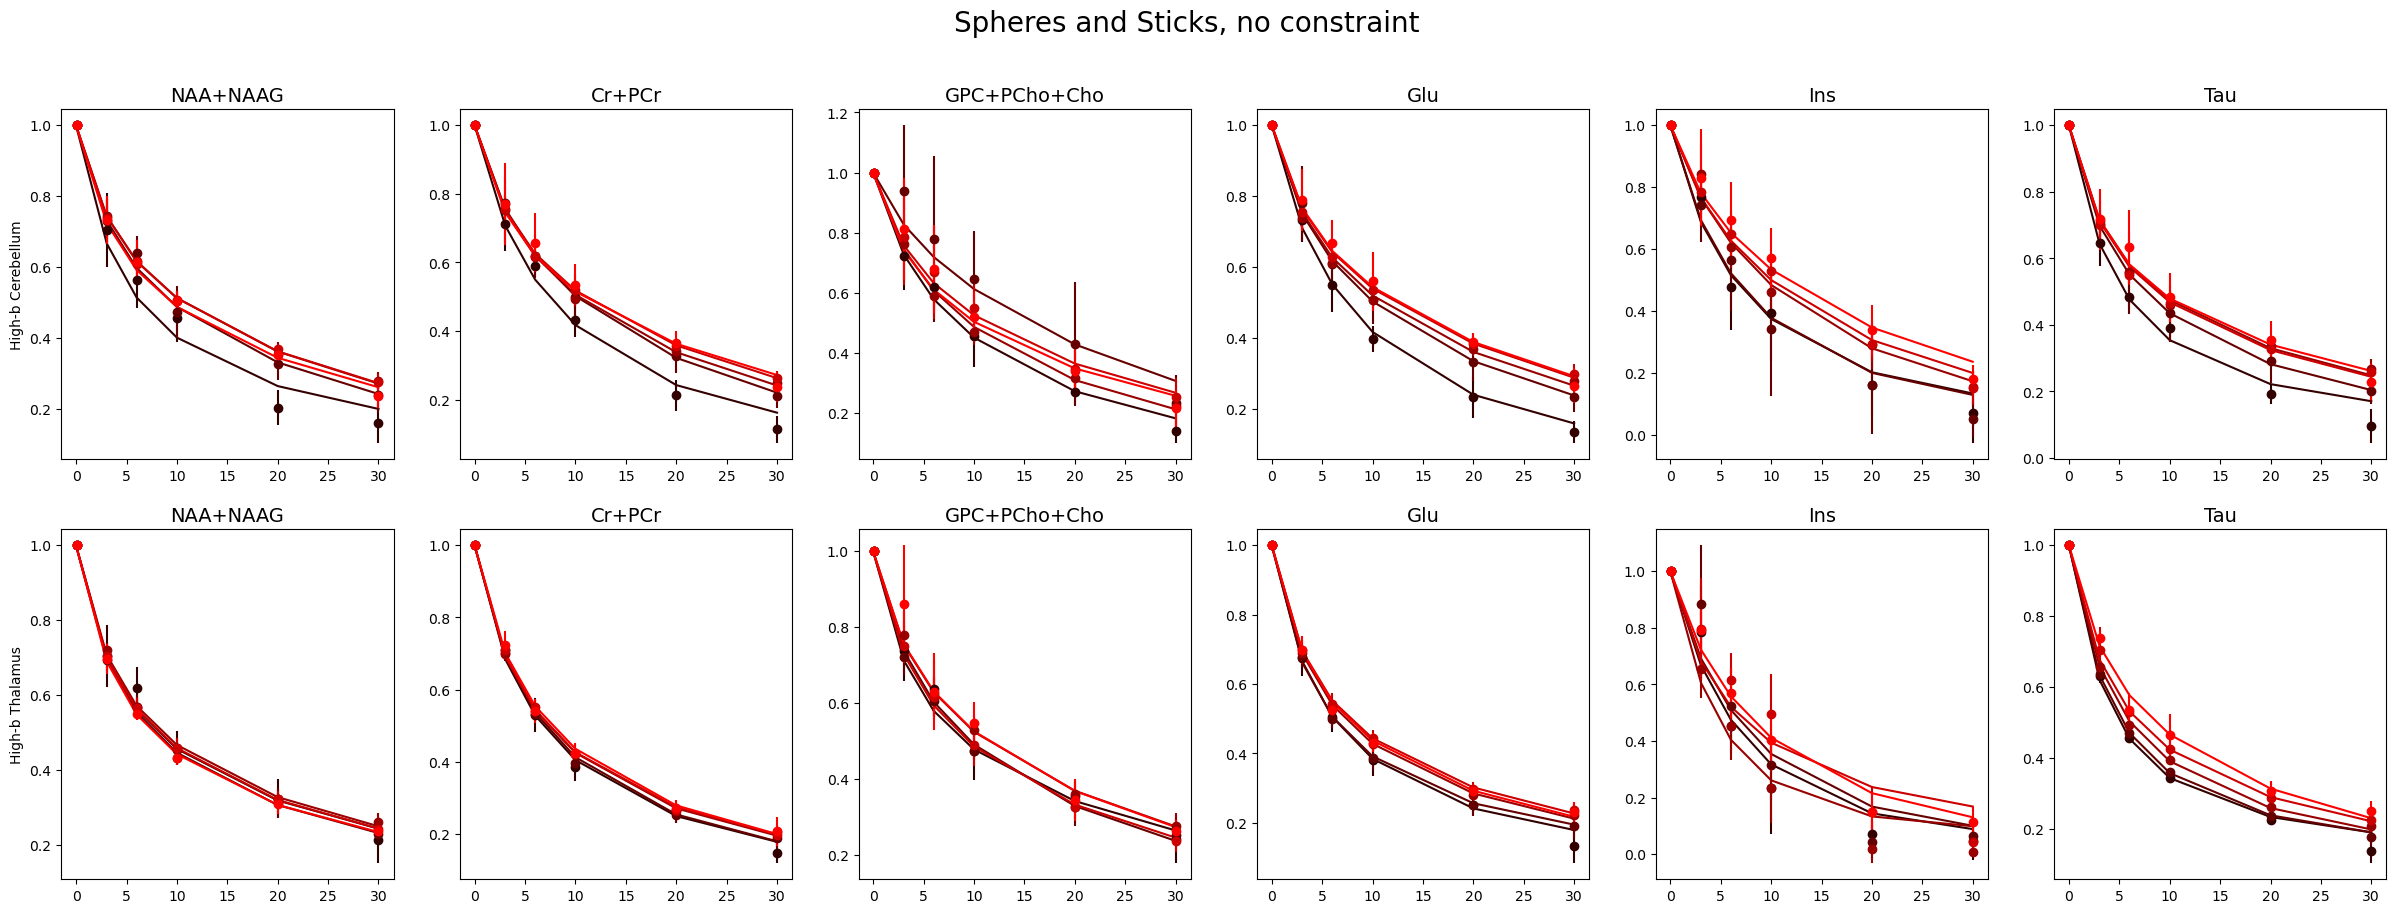

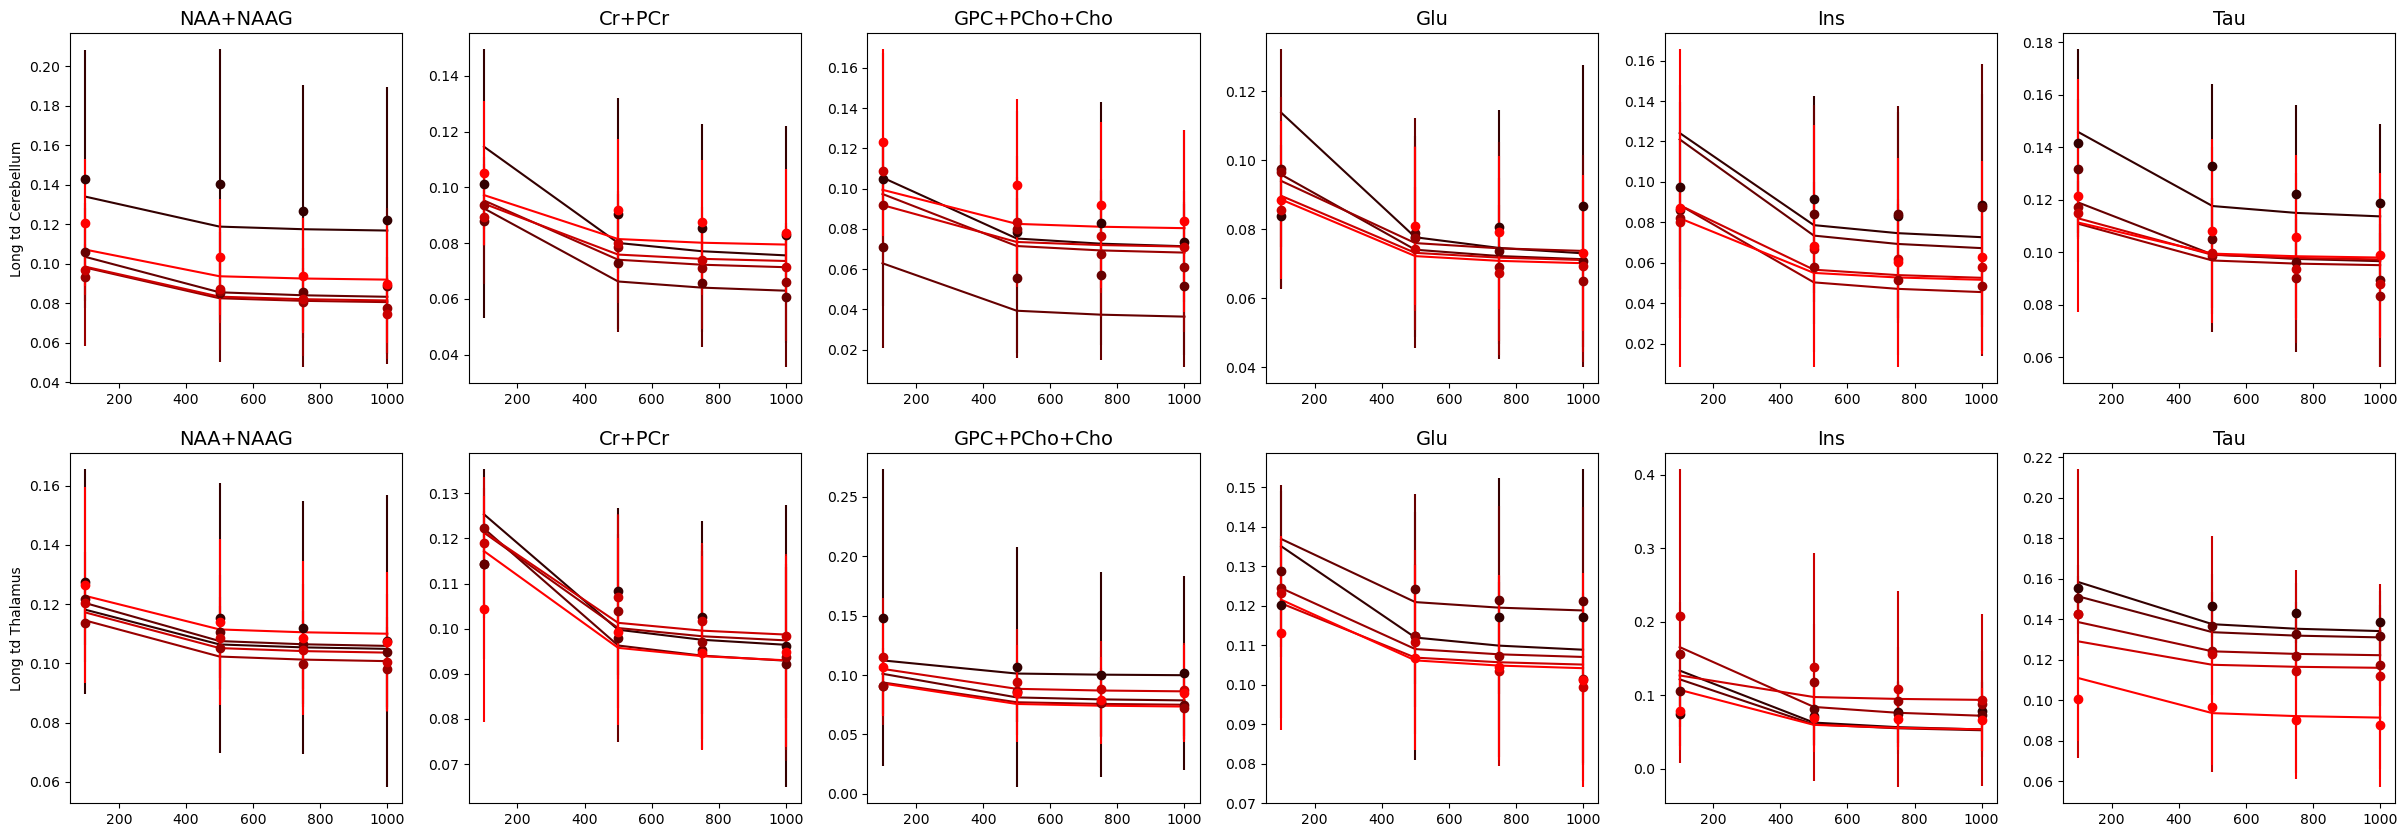

In [44]:
# plotting data

Ages        = [5, 10, 15, 20, 30]
Metabolites = ["NAA+NAAG", "Cr+PCr", "GPC+PCho+Cho", "Glu", "Ins", "Tau"]
Regions     = ["Cerebellum", "Thalamus"]

fig, axs = plt.subplots(nrows=len(Regions), ncols=len(Metabolites), figsize=(30, 10))
thalamcor=[(0.0, 0.0, 0.0),(0.25, 0., 0.),(0.5, 0., 0.),(0.75, 0., 0.),(1.0, 0., 0.)]

cerebcor=[(0.0, 0.12, 0.25),(0.0, 0.25, 0.5),(0.0, 0.4, 0.75),(0.0, 0.5, 1.0)];


#colors=[(0.2, 0., 0.),(0.4, 0., 0.),(0.6, 0., 0.),(0.8, 0., 0.),(1, 0., 0.)]

for i, metab in enumerate(Metabolites):
    for j, region in enumerate(Regions):
        
            for k, age in enumerate(Ages):
                    idx = resultsFit[(resultsFit["Age"]==age) & (resultsFit["Region"]==region) & (resultsFit["Metabolite"]==metab)].index.to_numpy()[0]
                    data = all_data[idx][0][0:6]
                    stddata = all_data[idx][1][0:6]
                    pred = all_data[idx][2][0:6]           
        
                    axs[j,i].plot(all_data[idx][5][0:6], pred, color=colors[k])
                    axs[j,i].errorbar(all_data[idx][5][0:6],data, yerr=stddata, fmt='o', color=colors[k])
                    axs[j,i].set_title(metab, fontsize=14)
                    fig.suptitle('Spheres and Sticks, no constraint', fontsize=20)

plt.setp(axs[0, 0], ylabel='High-b Cerebellum')
plt.setp(axs[1, 0], ylabel='High-b Thalamus')


fig2, axs2 = plt.subplots(nrows=len(Regions), ncols=len(Metabolites), figsize=(30, 10))

colors=[(0.2, 0., 0.),(0.4, 0., 0.),(0.6, 0., 0.),(0.8, 0., 0.),(1, 0., 0.)]

for i, metab in enumerate(Metabolites):
    for j, region in enumerate(Regions):
        for k, age in enumerate(Ages):
            idx = resultsFit[(resultsFit["Age"]==age) & (resultsFit["Region"]==region) & (resultsFit["Metabolite"]==metab)].index.to_numpy()[0]
            data = all_data[idx][0][6:10]
            stddata = all_data[idx][1][6:10]
            pred = all_data[idx][2][6:10]

            axs2[j,i].plot(all_data[idx][3][6:10], -np.log(pred)/3, color=colors[k])
            axs2[j,i].errorbar(all_data[idx][3][6:10],-np.log(data)/3, yerr=stddata, fmt='o', color=colors[k])   
            axs2[j,i].set_title(metab, fontsize=14)

plt.setp(axs2[0, 0], ylabel='Long td Cerebellum')
plt.setp(axs2[1, 0], ylabel='Long td Thalamus')            

In [50]:
print(all_data[18][3][6:10])

[ 100.  500.  750. 1000.]


## Residuals between models (supplementary info)

Residuals from the tested models: 

- 3 DL: astroticks + spheres, no fixed parameter
- 2 DL: astrosticks + spheres, Dintra fixed at 0.6 ms/µm2
- 2 DL: astrocylinders, no fixed parameter
- 1 DL: astrosticks only

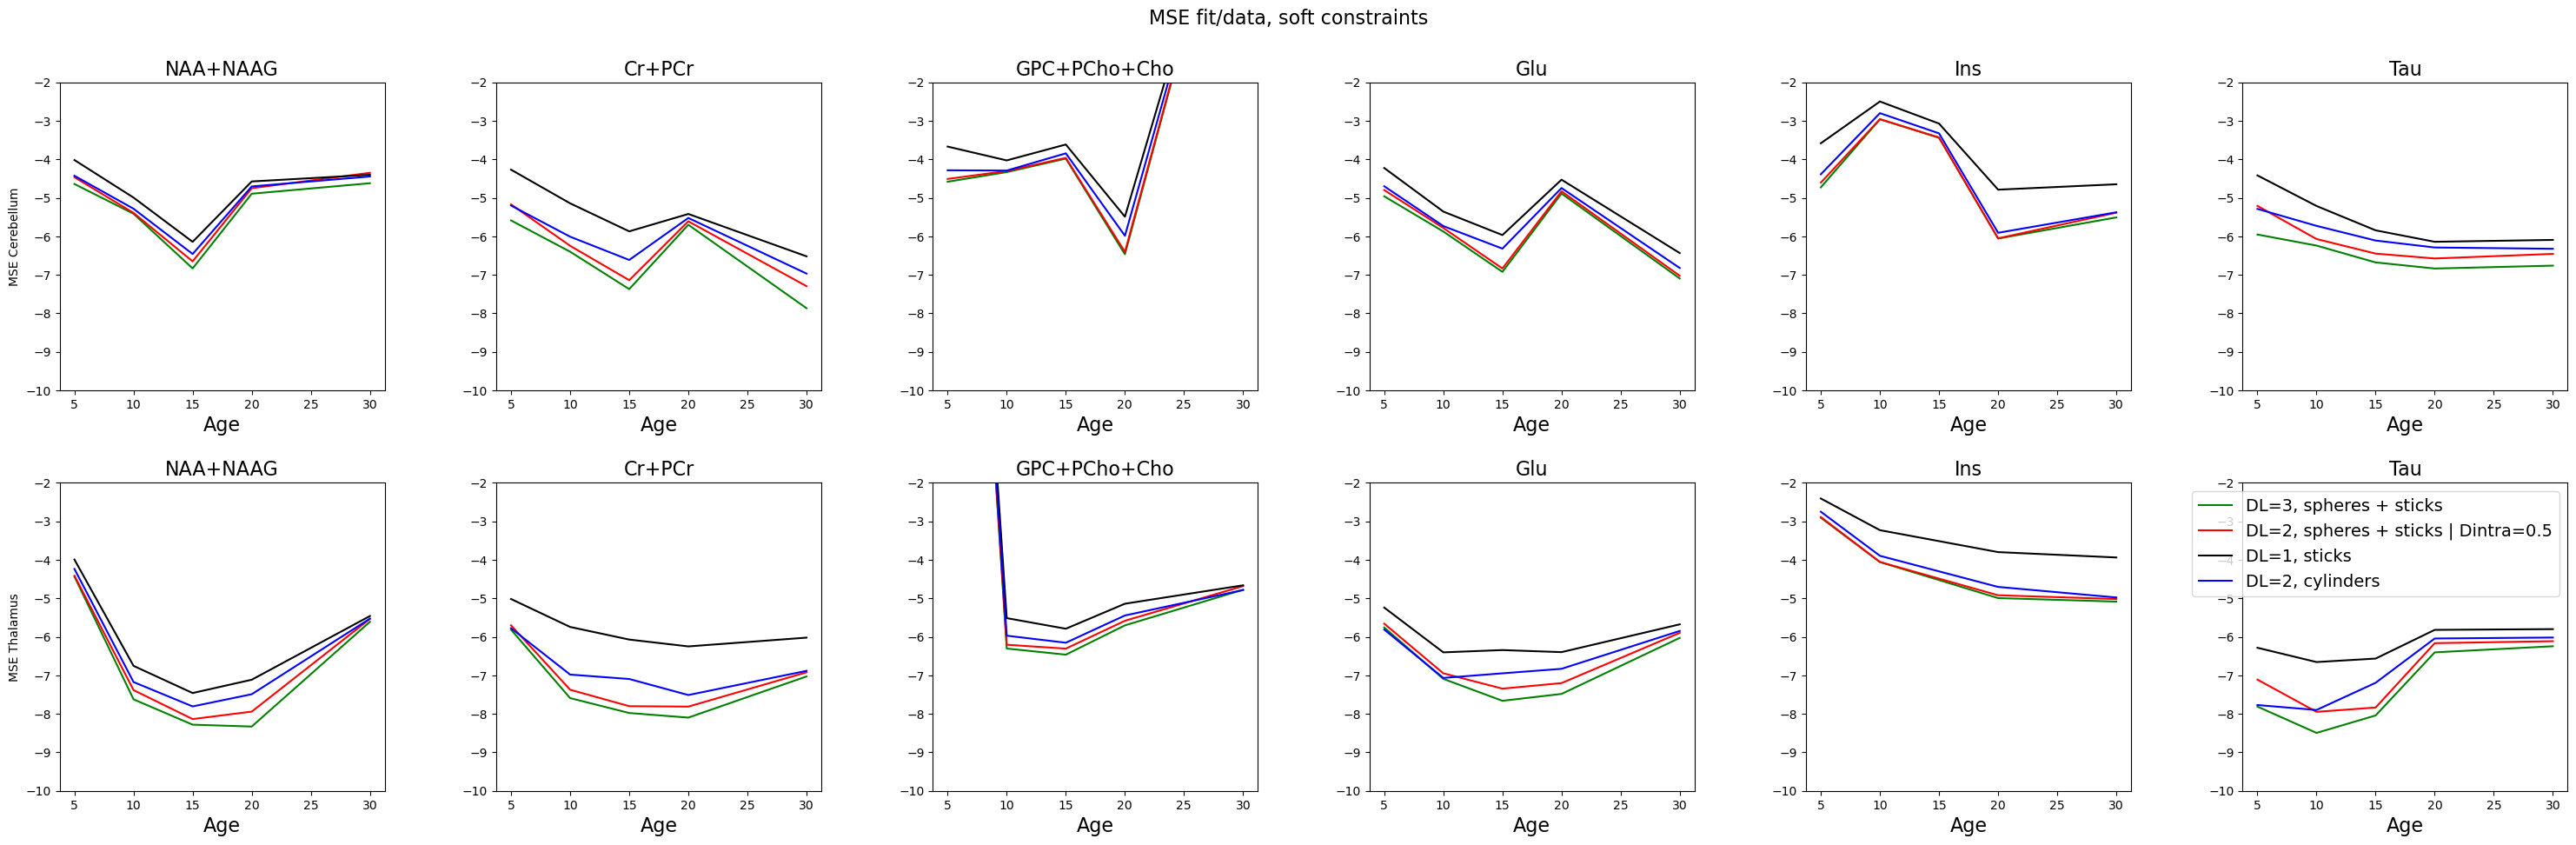

In [26]:
#plotting residuals

Ages        = [5, 10, 15, 20, 30]
Metabolites = ["NAA+NAAG", "Cr+PCr", "GPC+PCho+Cho", "Glu", "Ins", "Tau"]
Regions     = ["Cerebellum", "Thalamus"]

spheresS=pd.read_csv('Outputs/230919_Both_SpheresSticks_NB_IndivData.csv')
spheresSADC=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC05_IndivData.csv')
sticks=pd.read_csv('Outputs/230919_Both_Sticks_IndivData.csv')
cyls=pd.read_csv('Outputs/230919_Both_Cylinders_IndivData.csv')

fig, axs = plt.subplots(nrows=len(Regions), ncols=len(Metabolites), figsize=(30, 10))

colors=[(0.2, 0., 0.),(0.4, 0., 0.),(0.6, 0., 0.),(0.8, 0., 0.),(1, 0., 0.)]

for i, metab in enumerate(Metabolites):
    for j, region in enumerate(Regions):
            age_mse=spheresS[(spheresS["Region"]==region) & (spheresS["Metabolite"]==metab)].groupby('Age')['Age'].mean().to_numpy()  
            mse_spheresS=spheresS[(spheresS["Region"]==region) & (spheresS["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()
            mse_spheresSADC=spheresSADC[(spheresSADC["Region"]==region) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()
            mse_sticks=sticks[(sticks["Region"]==region) & (sticks["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()
            mse_cylinders=cyls[(cyls["Region"]==region) & (cyls["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()


            
            axs[j,i].plot(age_mse,np.log(mse_spheresS), color='g',label='DL=3, spheres + sticks')
            axs[j,i].plot(age_mse,np.log(mse_spheresSADC), color='r',label='DL=2, spheres + sticks | Dintra=0.5')
            axs[j,i].plot(age_mse,np.log(mse_sticks), color='k',label='DL=1, sticks')
            axs[j,i].plot(age_mse,np.log(mse_cylinders), color='b',label='DL=2, cylinders')
            
            axs[j,i].set_ylim([-10, -2])
            axs[j,i].set_title(metab, fontsize=16)
            axs[j,i].set_xlabel('Age', fontsize=16)
            #axs[j,i].legend(fontsize=10)
            fig.suptitle('MSE fit/data, soft constraints', fontsize=16)
plt.setp(axs[0, 0], ylabel='MSE Cerebellum')
plt.setp(axs[1, 0], ylabel='MSE Thalamus')
plt.legend(fontsize=14)
#fig.set_size_inches(18,7)
fig.tight_layout(pad=2)

In [1]:
# save figure
fig.savefig('RMSE-all-models.png', dpi=300, format='png' )

NameError: name 'fig' is not defined

Testing different values for Dintra (from 0.3 ms/µm2 to 0.8 ms/µm2) in the astrosticks + spheres model.

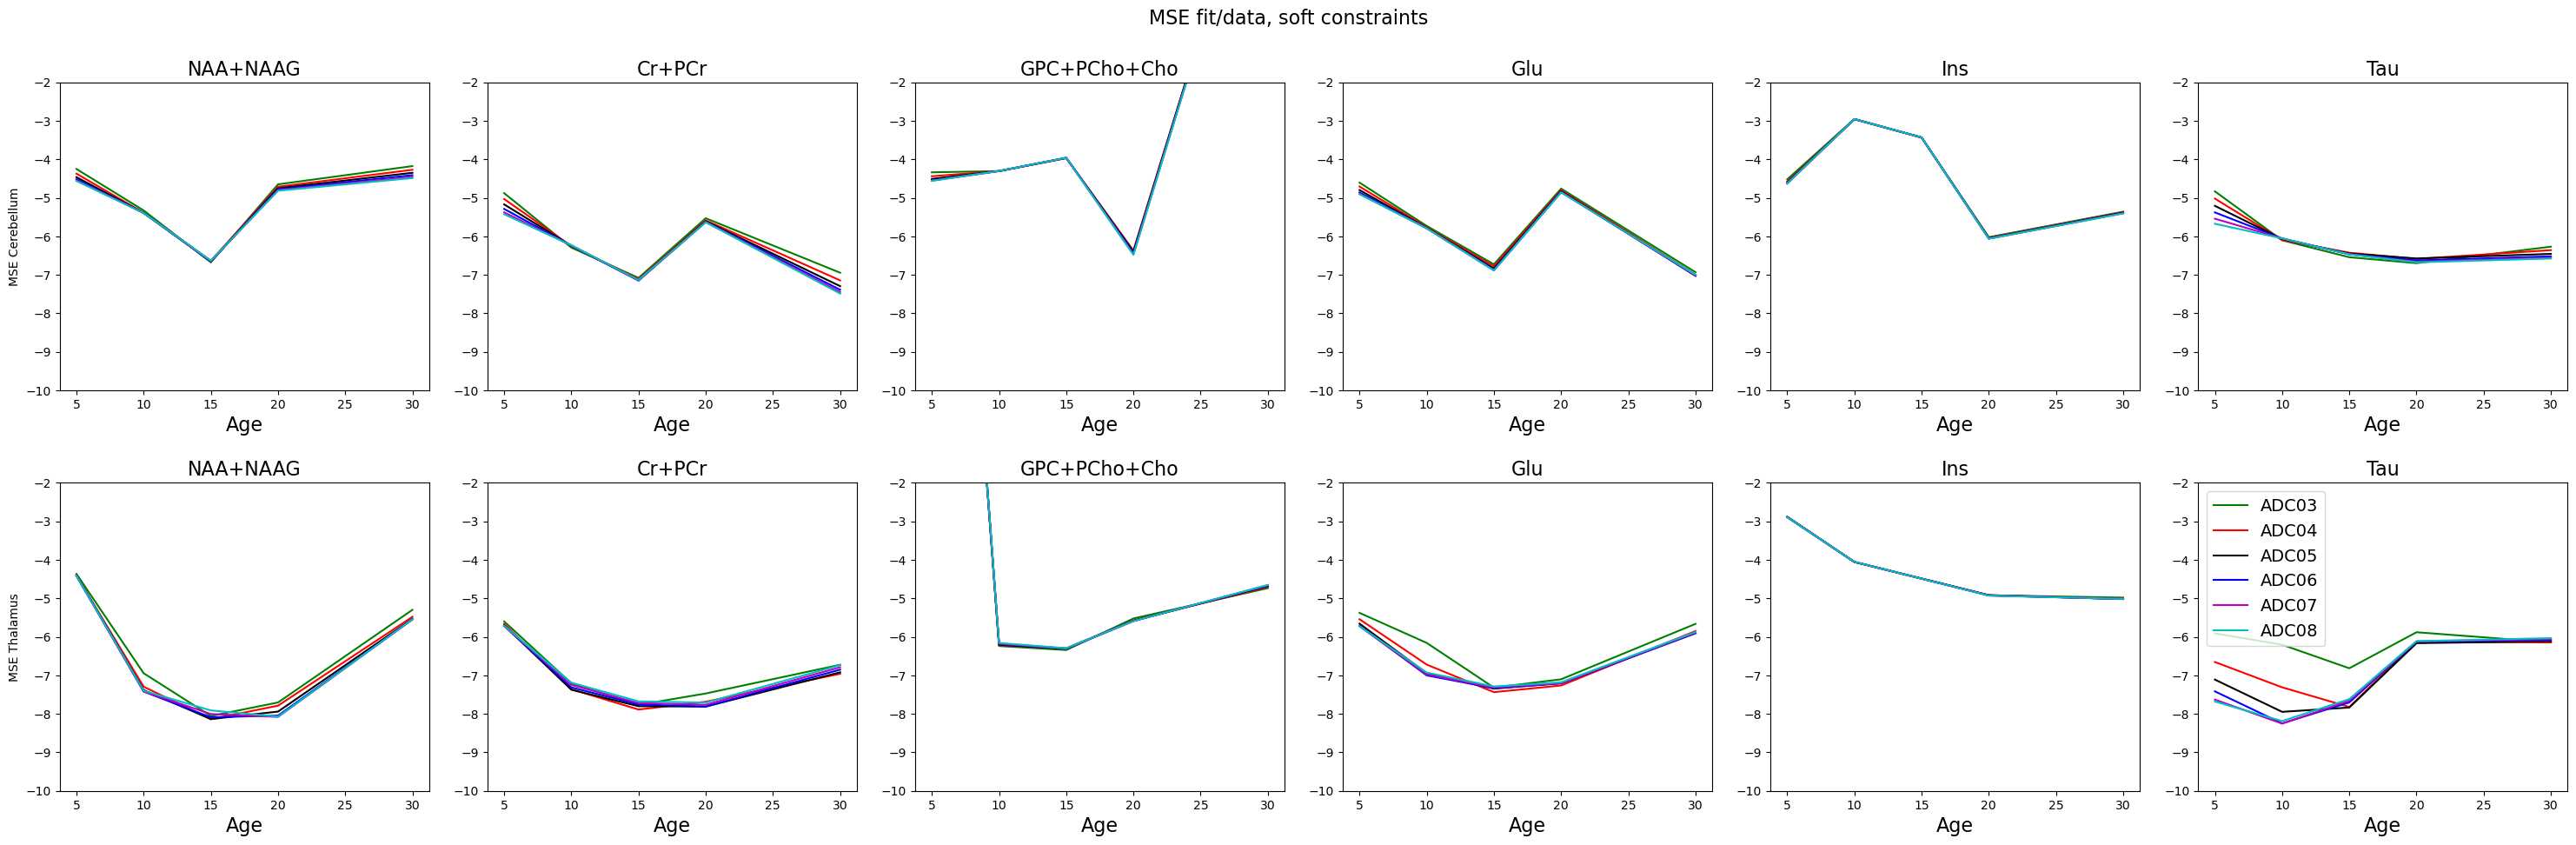

In [16]:
#plotting residuals

Ages        = [5, 10, 15, 20, 30]
Metabolites = ["NAA+NAAG", "Cr+PCr", "GPC+PCho+Cho", "Glu", "Ins", "Tau"]
Regions     = ["Cerebellum", "Thalamus"]

ADC03=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC03_IndivData.csv')
ADC04=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC04_IndivData.csv')
ADC05=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC05_IndivData.csv')
ADC06=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC06_IndivData.csv')
ADC07=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC07_IndivData.csv')
ADC08=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC08_IndivData.csv')

fig, axs = plt.subplots(nrows=len(Regions), ncols=len(Metabolites), figsize=(30, 10))

colors=[(0.2, 0., 0.),(0.4, 0., 0.),(0.6, 0., 0.),(0.8, 0., 0.),(1, 0., 0.)]

for i, metab in enumerate(Metabolites):
    for j, region in enumerate(Regions):
            age_mse=ADC03[(ADC03["Region"]==region) & (ADC03["Metabolite"]==metab)].groupby('Age')['Age'].mean().to_numpy()  
            mse_ADC03=ADC03[(ADC03["Region"]==region) & (ADC03["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()
            mse_ADC04=ADC04[(ADC04["Region"]==region) & (ADC04["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()
            mse_ADC05=ADC05[(ADC05["Region"]==region) & (ADC05["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()
            mse_ADC06=ADC06[(ADC06["Region"]==region) & (ADC06["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()
            mse_ADC07=ADC07[(ADC07["Region"]==region) & (ADC07["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()
            mse_ADC08=ADC08[(ADC08["Region"]==region) & (ADC08["Metabolite"]==metab)].groupby('Age')['MSE'].mean().to_numpy()



            
            axs[j,i].plot(age_mse,np.log(mse_ADC03), color='g',label='ADC03')
            axs[j,i].plot(age_mse,np.log(mse_ADC04), color='r',label='ADC04')
            axs[j,i].plot(age_mse,np.log(mse_ADC05), color='k',label='ADC05')
            axs[j,i].plot(age_mse,np.log(mse_ADC06), color='b',label='ADC06')
            axs[j,i].plot(age_mse,np.log(mse_ADC07), color='m',label='ADC07')
            axs[j,i].plot(age_mse,np.log(mse_ADC08), color='c',label='ADC08')
            
            axs[j,i].set_ylim([-10, -2])
            axs[j,i].set_title(metab, fontsize=16)
            axs[j,i].set_xlabel('Age', fontsize=16)
            #axs[j,i].legend(fontsize=10)
            fig.suptitle('MSE fit/data, soft constraints', fontsize=16)
plt.setp(axs[0, 0], ylabel='MSE Cerebellum')
plt.setp(axs[1, 0], ylabel='MSE Thalamus')
plt.legend(fontsize=14)
#fig.set_size_inches(18,7)
fig.tight_layout(pad=2)

In [17]:
# save figure
fig.savefig('RMSE-all-ADC.png', dpi=300, format='png' )

## Parameters landscape: sphere radius & sphere fraction for all ages in Cerebellum & Thalamus

Plotting the parameters landscape for the Cerebellum and saving the ordered param estimations in a dataframe to run stats (in R). 

Figure 4 & supplementary info

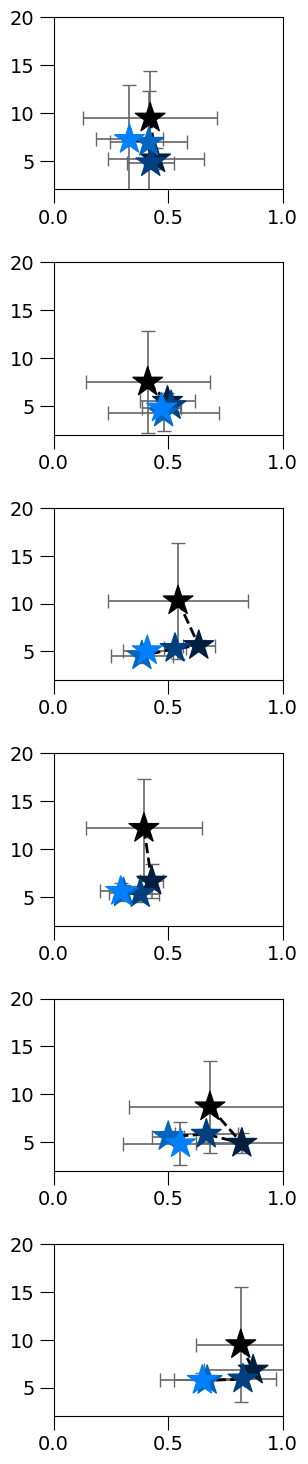

In [2]:
#plotting sphere function as a function of radius in the cerebellum for spheres & cylinders (Dintra)

Ages        = [5, 10, 15, 20, 30]
Metabolites = ["NAA+NAAG", "Glu","Cr+PCr", "Tau", "GPC+PCho+Cho",  "Ins"]
#Regions     = ["Cerebellum", "Thalamus"]
Regions     = 'Cerebellum'
spheresS=pd.read_csv('Outputs/230919_Both_SpheresSticks_NB_IndivData.csv')
spheresSADC=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC05_IndivData.csv')


fig, axs = plt.subplots(nrows=len(Metabolites), ncols=1, figsize=(10, 10))
cerebcor=[(0.0, 0.0, 0.0),(0.0, 0.12, 0.25),(0.0, 0.25, 0.5),(0.0, 0.4, 0.75),(0.0, 0.5, 1.0)];
FractionRadiusStats=[]

for i, metab in enumerate(Metabolites):
            age_mse=spheresS[(spheresS["Region"]==Regions) & (spheresS["Metabolite"]==metab)].groupby('Age')['Age'].mean().to_numpy()  
            R_spheresSADC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereRadius'].mean().to_numpy()
            frac_spheresSADC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereFraction'].mean().to_numpy()
            sd_R_spheresSADC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereRadius'].std().to_numpy()
            sd_frac_spheresSADC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereFraction'].std().to_numpy()
            FractionRadiusStats.append(np.array([age_mse,R_spheresSADC,frac_spheresSADC,sd_R_spheresSADC,sd_frac_spheresSADC]))


           
            axs[i].errorbar(frac_spheresSADC,R_spheresSADC,xerr=sd_frac_spheresSADC,yerr=sd_R_spheresSADC, color='k', ecolor=(0.4,0.4,0.4),elinewidth=1.2,capsize=5,linestyle='--', linewidth=2, zorder=1)
            axs[i].scatter(frac_spheresSADC,R_spheresSADC, color=cerebcor, marker='*', s=500, zorder=2)
            #axs[i].scatter(frac_spheresS,radius_spheresS, color=cerebcor, marker='*', s=400)
            axs[i].set_xlim([0, 1])
            axs[i].set_ylim([2,20])
            #axs[i].set_title(metab, fontsize=14)
            #axs[i].set_xlabel('Sphere Fraction', fontsize=12)
           # axs[i].set_ylabel('Sphere Radius', fontsize=12)
            axs[i].tick_params(axis='both',labelsize=14,length=10)
           # axs[i].legend()
fig.set_size_inches(3.5,15)
fig.tight_layout(pad=2)
#fig.suptitle('R(fraction) from P10 to P30', fontsize=20)





In [21]:
print(FractionRadiusStats)
np.shape(FractionRadiusStats)
FractionRadiusStatsT=np.reshape(FractionRadiusStats,(30,5))
np.shape(FractionRadiusStatsT)
print(FractionRadiusStatsT)
dfFractionRadiusStats=pd.DataFrame(FractionRadiusStatsT)

[array([[ 5.        , 10.        , 15.        , 20.        , 30.        ],
       [ 9.44462673,  5.18024246,  4.77722065,  6.91542167,  7.21186985],
       [ 0.421713  ,  0.44522544,  0.42414763,  0.41584847,  0.33122153],
       [ 4.91399049,  1.10170351,  0.57734199,  5.34072343,  5.65553781],
       [ 0.29324456,  0.2092579 ,  0.10150388,  0.16779373,  0.14590064]]), array([[ 5.        , 10.        , 15.        , 20.        , 30.        ],
       [ 7.49896077,  5.48937788,  5.03678325,  4.26397183,  4.79105274],
       [ 0.41077421,  0.49709951,  0.51314888,  0.48033378,  0.47093074],
       [ 5.2942769 ,  0.90527658,  0.24056368,  1.87751318,  0.11942833],
       [ 0.27091018,  0.1189792 ,  0.03852172,  0.24065163,  0.0858721 ]]), array([[ 5.        , 10.        , 15.        , 20.        , 30.        ],
       [10.28221896,  5.61033001,  5.30891273,  4.53672052,  5.06848507],
       [ 0.5432368 ,  0.63377869,  0.53012458,  0.38551661,  0.40903321],
       [ 6.08338561,  0.57601567,

In [21]:
dfFractionRadiusStats.to_csv('StatsCerebellum_ADC05.csv')

In [19]:
fig.savefig('Both-ADC06-Radius-Fraction-Age-Cereb-Indiv-TAU.png', dpi=300, format='png' )

Plotting the parameters landscape for the Thalamus and saving the ordered param estimations in a dataframe to run stats (in R). 

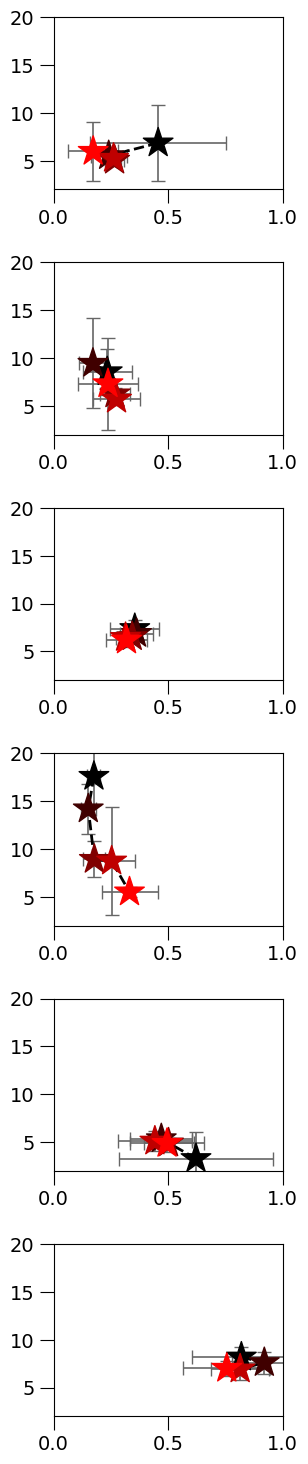

In [13]:
#plotting sphere function as a function of radius in the cerebellum for spheres & cylinders (Dintra)

Ages        = [5, 10, 15, 20, 30]
Metabolites = ["NAA+NAAG", "Glu","Cr+PCr", "Tau", "GPC+PCho+Cho","Ins"]
#Metabolites = ["Ins"]
#Regions     = ["Cerebellum", "Thalamus"]
Regions     = 'Thalamus'
spheresS=pd.read_csv('Outputs/230919_Both_SpheresSticks_NB_IndivData.csv')
spheresSADC=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC05_IndivData.csv')

fig, axs = plt.subplots(nrows=len(Metabolites), ncols=1, figsize=(10, 10))
thalamcor=[(0.0, 0.0, 0.0),(0.25, 0., 0.),(0.5, 0., 0.),(0.75, 0., 0.),(1.0, 0., 0.)]
thalamcorP15=[(0.0, 0.0, 0.0),(0.25, 0., 0.),(0.75, 0., 0.),(1.0, 0., 0.)]

#cerebcor=[(0.0, 0.12, 0.25),(0.0, 0.25, 0.5),(0.0, 0.4, 0.75),(0.0, 0.5, 1.0)];
FractionRadiusStats=[]

for i, metab in enumerate(Metabolites):
            age_mse=spheresS[(spheresS["Region"]==Regions) & (spheresS["Metabolite"]==metab)].groupby('Age')['Age'].mean().to_numpy()  
            R_spheresSADC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereRadius'].mean().to_numpy()
            frac_spheresSADC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereFraction'].mean().to_numpy()
            sd_R_spheresSADC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereRadius'].std().to_numpy()
            sd_frac_spheresSADC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereFraction'].std().to_numpy()
            


           
            #axs[i].errorbar(frac_spheresSADC,R_spheresSADC,xerr=sd_frac_spheresSADC,yerr=sd_R_spheresSADC, color='k', ecolor=(0.5,0.5,0.5),elinewidth=1,capsize=5,linestyle='--', linewidth=1.5, zorder=1)

           
            
           # inositol at P15 is poorly fitted 
            if i==5:
                axs[i].errorbar(frac_spheresSADC,R_spheresSADC,xerr=sd_frac_spheresSADC,yerr=sd_R_spheresSADC, color='k', ecolor=(0.4,0.4,0.4),elinewidth=1.2,capsize=5,linestyle='--', linewidth=2, zorder=1)
                axs[i].scatter(frac_spheresSADC,R_spheresSADC, color=thalamcorP15, marker='*', s=500, zorder=2)  
                # uncomment to save inositol stats
                #FractionRadiusStats.append(np.array([age_mse,R_spheresSADC,frac_spheresSADC,sd_R_spheresSADC,sd_frac_spheresSADC]))
            else:
                axs[i].errorbar(frac_spheresSADC,R_spheresSADC,xerr=sd_frac_spheresSADC,yerr=sd_R_spheresSADC, color='k', ecolor=(0.4,0.4,0.4),elinewidth=1.2,capsize=5,linestyle='--', linewidth=2, zorder=1)
                axs[i].scatter(frac_spheresSADC,R_spheresSADC, color=thalamcor, marker='*', s=500, zorder=2)  
                # uncomment to save all stats 
                FractionRadiusStats.append(np.array([age_mse,R_spheresSADC,frac_spheresSADC,sd_R_spheresSADC,sd_frac_spheresSADC]))

            #axs[i].scatter(frac_spheresS,radius_spheresS, color=cerebcor, marker='*', s=400)
            axs[i].set_xlim([0, 1])
            axs[i].set_ylim([2,20])
            #axs[i].set_title(metab, fontsize=14)
            #axs[i].set_xlabel('Sphere Fraction', fontsize=12)
           # axs[i].set_ylabel('Sphere Radius', fontsize=12)
            axs[i].tick_params(axis='both',labelsize=14,length=10)
           # axs[i].legend()
fig.set_size_inches(3.5,15)
fig.tight_layout(pad=2)
#fig.suptitle('R(fraction) from P10 to P30', fontsize=20)

In [14]:
print(FractionRadiusStats)
np.shape(FractionRadiusStats)
# Save inositol
#FractionRadiusStatsT=np.reshape(FractionRadiusStats,(5,4))
# Save without inositol
FractionRadiusStatsT=np.reshape(FractionRadiusStats,(25,5))
np.shape(FractionRadiusStatsT)
print(FractionRadiusStatsT)
dfFractionRadiusStats=pd.DataFrame(FractionRadiusStatsT)

[array([[ 5.        , 10.        , 15.        , 20.        , 30.        ],
       [ 6.84451024,  5.51652193,  5.04525449,  5.24202725,  5.96849271],
       [ 0.45652373,  0.24072241,  0.26659627,  0.26199593,  0.17307479],
       [ 3.9586623 ,  0.77249926,  0.59317678,  0.55213061,  3.08107253],
       [ 0.29686493,  0.0787328 ,  0.04009747,  0.03276021,  0.10767461]]), array([[ 5.        , 10.        , 15.        , 20.        , 30.        ],
       [ 8.57456692,  9.46030746,  6.26126088,  5.71254222,  7.32397741],
       [ 0.23451639,  0.17198167,  0.26804881,  0.27500001,  0.23764514],
       [ 2.42352042,  4.70027544,  0.61596939,  0.61625337,  4.81852587],
       [ 0.10584547,  0.05985638,  0.06578543,  0.10217512,  0.12949444]]), array([[5.00000000e+00, 1.00000000e+01, 1.50000000e+01, 2.00000000e+01,
        3.00000000e+01],
       [7.38151357e+00, 6.87084510e+00, 6.53035624e+00, 6.44989804e+00,
        6.18267253e+00],
       [3.54552677e-01, 3.62265311e-01, 3.43347896e-01, 3.143

In [55]:
dfFractionRadiusStats.to_csv('StatsThalamus-Ins-noP15.csv')
#dfFractionRadiusStats.to_csv('StatsThalamus-noIns.csv')

In [23]:
fig.savefig('Both-ADC05-Radius-Fraction-Age-Thalam-Indiv-TAU.png', dpi=300, format='png' )

Plotting overlay for visualisation (supplementary info)

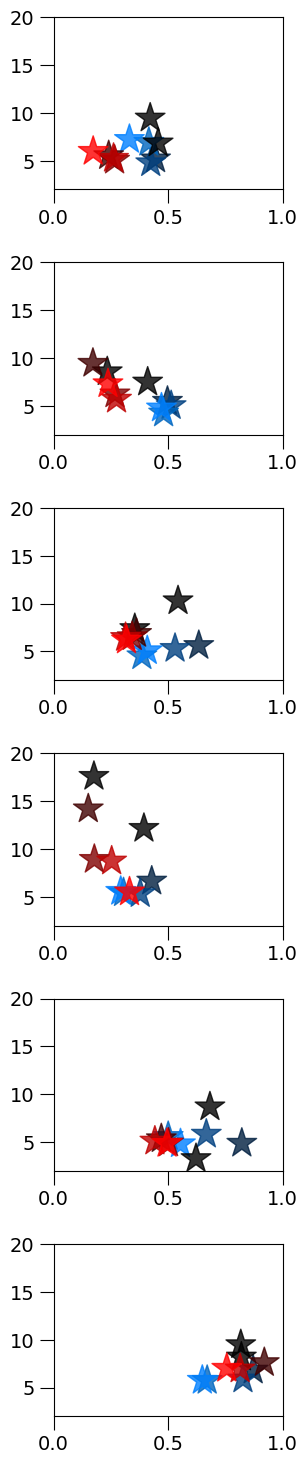

In [19]:
#plotting overlayed

Ages        = [5, 10, 15, 20, 30]
Metabolites = ["NAA+NAAG", "Glu","Cr+PCr", "Tau", "GPC+PCho+Cho",  "Ins"]
#Regions     = ["Cerebellum", "Thalamus"]
Regions     = 'Cerebellum'
spheresS=pd.read_csv('Outputs/230919_Both_SpheresSticks_NB_IndivData.csv')
spheresSADC=pd.read_csv('Outputs/230919_Both_SpheresSticks_ADC05_IndivData.csv')


fig, axs = plt.subplots(nrows=len(Metabolites), ncols=1, figsize=(10, 10))
cerebcor=[(0.0, 0.0, 0.0),(0.0, 0.12, 0.25),(0.0, 0.25, 0.5),(0.0, 0.4, 0.75),(0.0, 0.5, 1.0)];
thalamcor=[(0.0, 0.0, 0.0),(0.25, 0., 0.),(0.5, 0., 0.),(0.75, 0., 0.),(1.0, 0., 0.)]
thalamcorP15=[(0.0, 0.0, 0.0),(0.25, 0., 0.),(0.75, 0., 0.),(1.0, 0., 0.)]

for i, metab in enumerate(Metabolites):
            age_mse=spheresS[(spheresS["Region"]==Regions) & (spheresS["Metabolite"]==metab)].groupby('Age')['Age'].mean().to_numpy()  
            R_spheresSADCC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereRadius'].mean().to_numpy()
            frac_spheresSADCC=spheresSADC[(spheresSADC["Region"]==Regions) & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereFraction'].mean().to_numpy()
            R_spheresSADCT=spheresSADC[(spheresSADC["Region"]=='Thalamus') & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereRadius'].mean().to_numpy()
            frac_spheresSADCT=spheresSADC[(spheresSADC["Region"]=='Thalamus') & (spheresSADC["Metabolite"]==metab)].groupby('Age')['SphereFraction'].mean().to_numpy()
            if i==5:
                axs[i].scatter(frac_spheresSADCC,R_spheresSADCC, color=cerebcor, marker='*', s=500, zorder=1, alpha=0.8)
                axs[i].scatter(frac_spheresSADCT,R_spheresSADCT, color=thalamcorP15, marker='*', s=500, zorder=2, alpha=0.8)  
            else:
                axs[i].scatter(frac_spheresSADCC,R_spheresSADCC, color=cerebcor, marker='*', s=500, zorder=1, alpha=0.8)
                axs[i].scatter(frac_spheresSADCT,R_spheresSADCT, color=thalamcor, marker='*', s=500, zorder=2, alpha=0.8)    
   
                       #axs[i].scatter(frac_spheresS,radius_spheresS, color=cerebcor, marker='*', s=400)
            axs[i].set_xlim([0, 1])
            axs[i].set_ylim([2,20])
            #axs[i].set_title(metab, fontsize=14)
            #axs[i].set_xlabel('Sphere Fraction', fontsize=12)
           # axs[i].set_ylabel('Sphere Radius', fontsize=12)
            axs[i].tick_params(axis='both',labelsize=14,length=10)
           # axs[i].legend()
fig.set_size_inches(3.5,15)
fig.tight_layout(pad=2)
#fig.suptitle('R(fraction) from P10 to P30', fontsize=20)

In [12]:
fig.savefig('Both-ADC05-Radius-Fraction-Age-Thalam-and-Cereb-Indiv-TAU.png', dpi=300, format='png' )